In [1]:
## IPython extensions to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import torch

import random
import numpy as np
import os, sys

from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Draw,
    AllChem,
    PandasTools,
    MolFromSequence,
    MolToSmiles,
    MolToInchiKey,
    MolFromSmiles,
    Descriptors,
    GraphDescriptors,
    rdMolDescriptors as rdmdesc,
)

RDLogger.DisableLog("rdApp.*")
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


ROOT_DIR = os.sep.join(os.path.abspath(".").split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

from lib import (
    gnn_utils,
    utilities,
    datasets,
    splitters,
    featurizers,
    training_utils,
    graph_nns,
    visuals,
    predictions,
)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
## Set seeds
seed = 123
utilities.set_seeds(seed=seed, torch_use_deterministic_algos=False)

<p style="font-family: cursive; font-size=14px">
In this notebook, we will train some graph neural networks for node classification tasks. We will use the Planetoid library, which is available in <a href="https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html">PyTorch</a>.
</p>
<p style="font-family: cursive; font-size=14px">
In particular, we will work on the Cora dataset. It is a citation network dataset used for graph-based machine learning. The primary task is node classification, where the goal is to predict the academic topic (class) of each publication (node) based on the structure of the citation network and the feature attributes of the nodes.
</p>

In [4]:
from torch_geometric.datasets import Planetoid

cora_dataset = Planetoid(root=DATASET_DIR, name="Cora", split="public")

## Let's see hsome attributes of Planetoid datasets and graphs
print(dir(cora_dataset))

# num_classes, num_features, num_node_features, get_summary
print(f"\nNumber of graphs:        {len(cora_dataset)}")
print(f"Number of features:      {cora_dataset.num_features}")
print(f"Number of node features: {cora_dataset.num_node_features}")
# print(f"Number of edges:       {cora_dataset.num_edges}")
# print(f"Number of edge features:       {cora_dataset.num_edge_features}")
print(f"Number of classes:       {cora_dataset.num_classes}")
print(f"Summary:\n{cora_dataset.get_summary()}")

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'cpu', 'cuda', 'data', 'download', 'force_reload', 'geom_gcn_url', 'get', 'get_summary', 'has_download', 'has_process', 'index_select', 'indices', 'len', 'load', 'log', 'name', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_file_names', 'raw_p

In [5]:
cora_data_0 = cora_dataset[0]
print("\n", dir(cora_data_0))

# We see interesting graph attributes that could provide some useful information:
# has_isolated_nodes, has_self_loops, is_directed, train_mask, test_mask, val_mask
# is_coalesced,

print(f"\nNumber of attributes:       {len(cora_data_0)}")
print(f"First item:                {cora_data_0}")
print(f"Number of nodes:           {cora_data_0.x.shape[0]}")
print(f"Number of training nodes:  {cora_data_0.train_mask.sum().item()}")
print(f"Number of val nodes:       {cora_data_0.val_mask.sum().item()}")
print(f"Number of test nodes:      {cora_data_0.test_mask.sum().item()}")

print(f"\nhas isolated nodes ?:   {cora_data_0.has_isolated_nodes()}")
print(f"has_self_loops ?:       {cora_data_0.has_self_loops()}")
print(f"is directed ?:          {cora_data_0.is_directed()}")
print(
    f"is coalesced ?:         {cora_data_0.is_coalesced()}"
)  # i.e.: contains nodes or edges that have been merged (usually to reduce graph
# complexity and focus on the high-level structure)


 ['__abstractmethods__', '__annotations__', '__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_edge_attr_cls', '_edge_to_layout', '_edges_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tensor', '_remove_edge_index', '_remove_tensor', '_store', '_tensor_attr_cls', '_to_type', 'apply', 'apply_', 'batch', 'clone', 'coalesce', 'concat', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'coo', 'cpu', 'cs

<h4 style="font-family: cursive">Neighbor Sampling</h4>
<p style="font-family: cursive; font-size=14px">
Neighbor sampling in graph node classification is a technique used to reduce computational load by selecting a subset of a node's neighbors instead of using the entire neighborhood during training. It randomly samples a fixed number of neighbors at each layer, allowing the model to focus on a smaller, representative portion of the graph. This is particularly useful in large graphs, where using all neighbors would be too resource-intensive. A good tutorial is provided in this <a href="https://medium.com/@avla2023/neighborloader-introduction-ccb870cc7294">NeighborLoader Introduction.</a>
</p>

In [6]:
# Create batches with neighbor sampling.
train_loader = NeighborLoader(
    cora_data_0,
    num_neighbors=[
        5,
        10,
    ],  # This shows the number of neighbors to consider at each GNN layer
    batch_size=32,  # The number of seed nodes (first nodes in the batch)
    input_nodes=cora_data_0.train_mask,  # The indices of nodes for which neighbors are sampled to create mini-batches
    # Needs to be either given as a torch.LongTensor or torch.BoolTensor
)

val_loader = NeighborLoader(
    cora_data_0,
    num_neighbors=[
        5,
        10,
    ],  # This shows the number of neighbors to consider at each GNN layer
    batch_size=32,  # The number of seed nodes (first nodes in the batch)
    input_nodes=cora_data_0.val_mask,  # The indices of nodes for which neighbors are sampled to create mini-batches
    # Needs to be either given as a torch.LongTensor or torch.BoolTensor
)

test_loader = NeighborLoader(
    cora_data_0,
    num_neighbors=[
        5,
        10,
    ],  # This shows the number of neighbors to consider at each GNN layer
    batch_size=32,  # The number of seed nodes (first nodes in the batch)
    input_nodes=cora_data_0.test_mask,  # The indices of nodes for which neighbors are sampled to create mini-batches
    # Needs to be either given as a torch.LongTensor or torch.BoolTensor
)


print(f"Number of subgraphs : {len(train_loader)}")
# Print each subgraph.
for i, subgraph in enumerate(train_loader):
    print(f"Subgraph {i}: {subgraph}")

Number of subgraphs : 5
Subgraph 0: Data(x=[372, 1433], edge_index=[2, 601], y=[372], train_mask=[372], val_mask=[372], test_mask=[372], n_id=[372], e_id=[601], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[32], batch_size=32)
Subgraph 1: Data(x=[456, 1433], edge_index=[2, 637], y=[456], train_mask=[456], val_mask=[456], test_mask=[456], n_id=[456], e_id=[637], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[32], batch_size=32)
Subgraph 2: Data(x=[400, 1433], edge_index=[2, 624], y=[400], train_mask=[400], val_mask=[400], test_mask=[400], n_id=[400], e_id=[624], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[32], batch_size=32)
Subgraph 3: Data(x=[354, 1433], edge_index=[2, 590], y=[354], train_mask=[354], val_mask=[354], test_mask=[354], n_id=[354], e_id=[590], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[32], batch_size=32)
Subgraph 4: Data(x=[161, 1433], edge_index=[2, 242], y=[161], train_mask=[161], val_mask=[161], test_mask=[161], n_id=[161],

In [7]:
# from torch.utils.data import DataLoader
from torch_geometric.loader import NodeLoader, LinkLoader
from typing import Union
from matplotlib import pyplot as plt
import networkx as nx


def plot_subgraphs_from_loader(loader: Union[NodeLoader, LinkLoader]):
    # Plot each subgraph
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))
    for idx, (subdata, pos) in enumerate(zip(loader, axes.flat)):
        G = to_networkx(subdata, to_undirected=True)
        ax = fig.add_subplot(pos)
        ax.set_title(f"Subgraph {idx}", fontsize=24)
        plt.axis("off")
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, seed=0),
            with_labels=False,
            node_color=subdata.y,
        )
    plt.show()

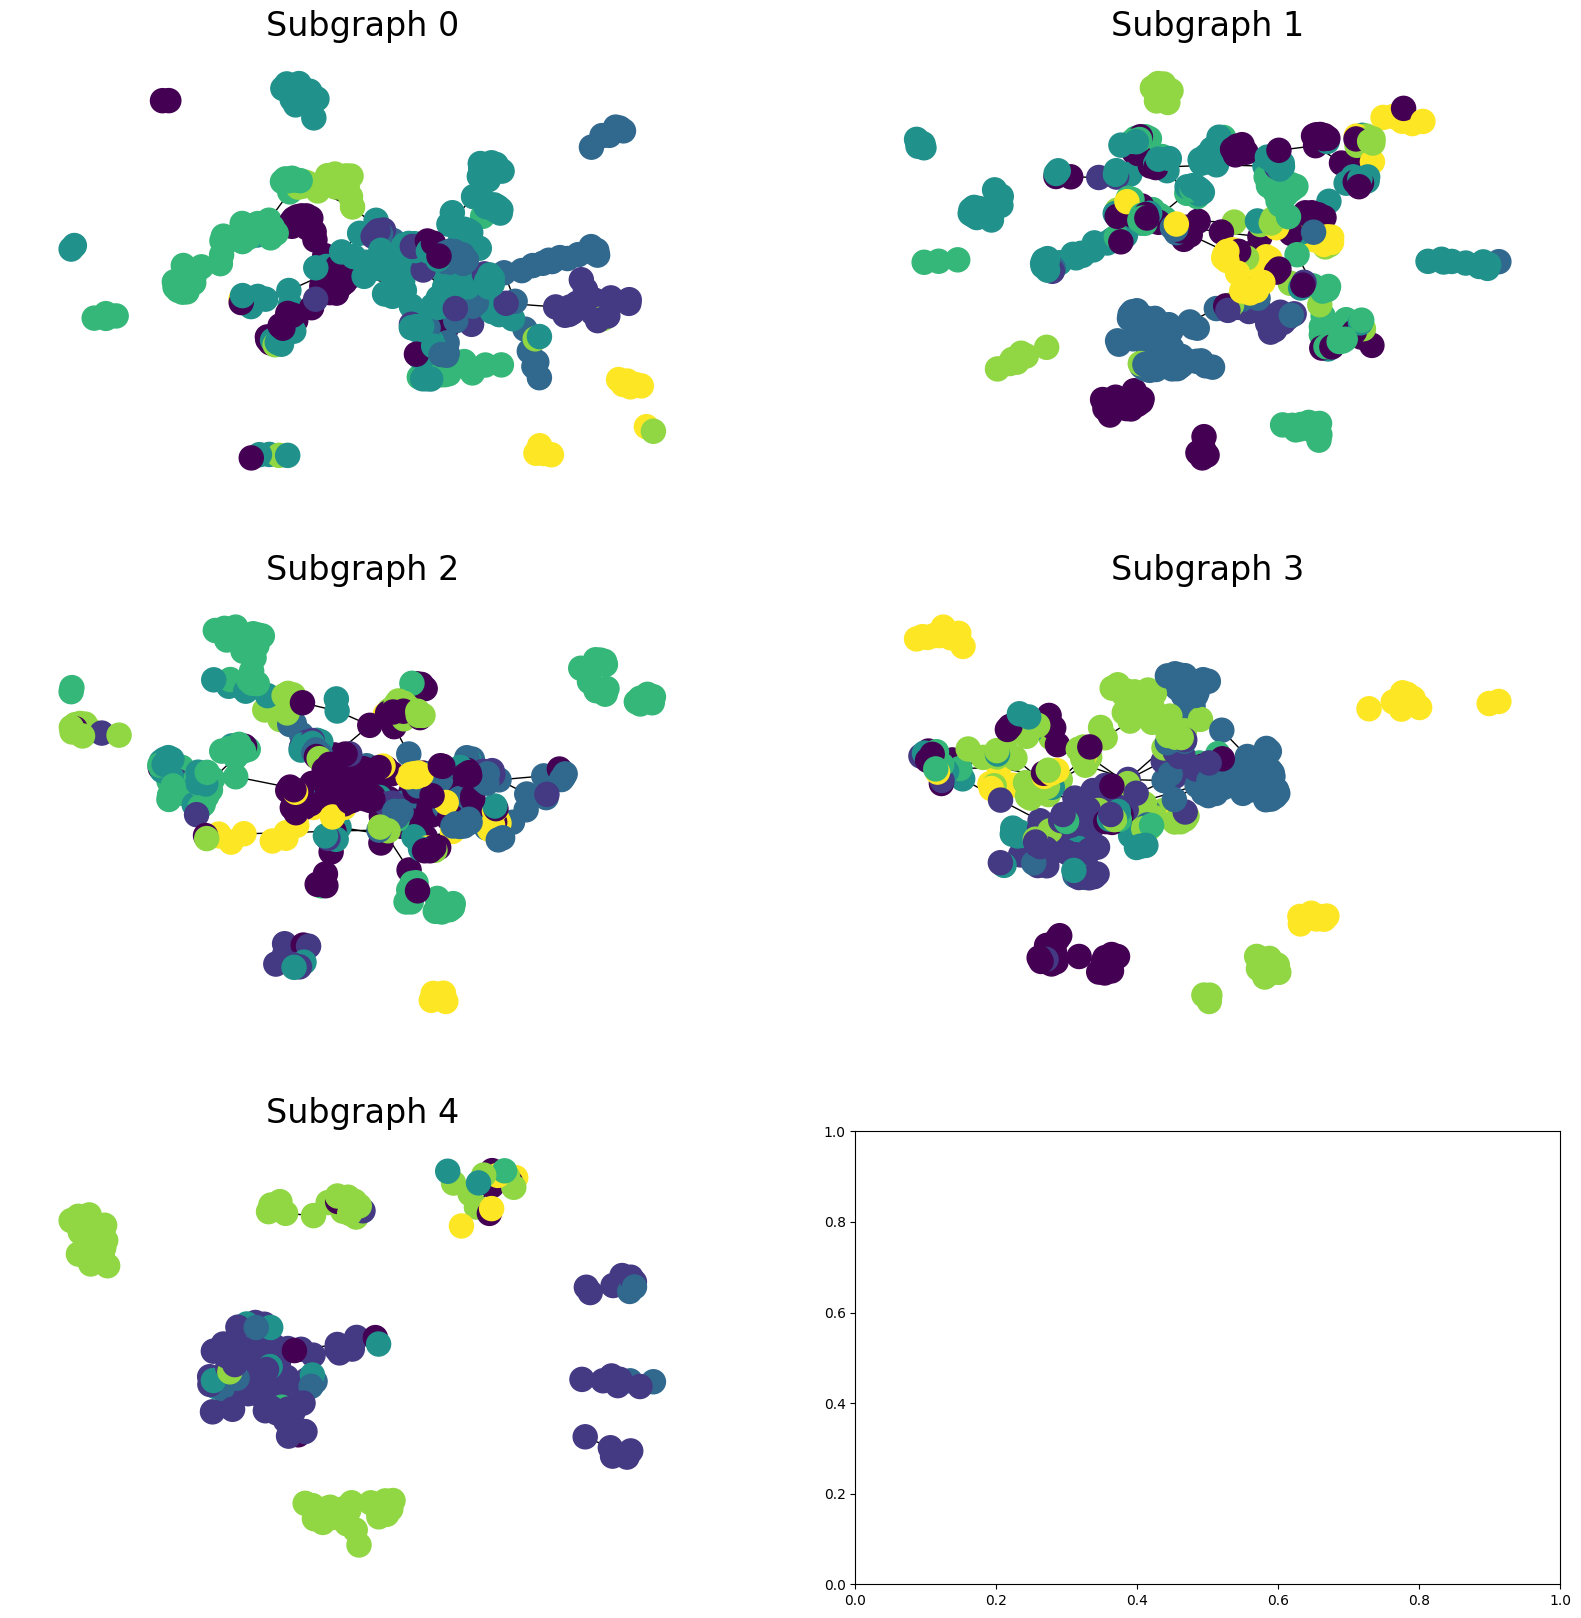

In [8]:
plot_subgraphs_from_loader(loader=train_loader)

In [9]:
from torch.nn import CrossEntropyLoss, functional as F
from torch import argmax

gcn_model = graph_nns.GCN(
    task="multiclass_classification",
    in_channels=1433,
    global_fdim=None,
    gnn_hidden_neurons=128,
    gnn_nlayers=2,
    ffn_hidden_neurons=128,
    ffn_nlayers=1,
    out_neurons=cora_dataset.num_classes,
    dropout_rate=0.3,
    gpooling_func=None,
    activation_func=torch.nn.LeakyReLU(),
    init_type=None,  # Initialization function, e.g.: kaiming_normal,xavier_uniform etc.
)
print("gcn_model", gcn_model)

GCN passed global_fdim =  None

self.global_fdim = None


GLOBAL FDIM: None
Initializing parameters...
gcn_model GCN(
  (activation_func): LeakyReLU(negative_slope=0.01)
  (conv1): GCNConv(1433, 128)
  (convs): ModuleList(
    (0): GCNConv(128, 128)
  )
  (ffn): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [10]:
criterion = CrossEntropyLoss()


in_channels = cora_data_0.num_features
global_fdim = (
    None
    if not hasattr(cora_data_0, "global_feats")
    else cora_data_0.global_feats.shape[1]
)
out_neurons = cora_dataset.num_classes

exp_params_grid = {
    "task": "multiclass_classification",
    "in_channels": in_channels,
    "global_fdim": global_fdim,
    "model": ["graph_nns.GCN"],  # , 'graph_nns.GAT'
    # 'gnn_hidden_neurons': [128, 256, 384, 512]
    "gnn_hidden_neurons": [150, 500],
    "gnn_nlayers": [1, 2]
    # , 'ffn_hidden_neurons': [64, 128, 256, 384, 512]
    ,
    "ffn_hidden_neurons": [100, 300],
    "ffn_nlayers": [1, 2],
    "out_neurons": out_neurons,
    "dropout_rate": [0.2, 0.6],
    "activation_func": ["torch.nn.LeakyReLU", "torch.nn.ReLU"],
    "gpooling_func": None  # no pulling for Node-level tasks here.
    # , 'heads' : [5,8]
    # , 'edge_dim': [2,8]
    # , 'add_edge_features': False
    ,
    "learning_rate": [5e-2, 1e-2],
    "n_epochs": [30, 50],
    "criterion": criterion,
    "optimizer": ["{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}"]
    # , 'scheduler' : ["{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.7, 'patience':30, 'threshold':5e-02, 'eps':1e-08}"],
    ,
    "scheduler": [
        "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.15, 'step_size_up':100, 'cycle_momentum':True}"
    ],
    "scoring_func": [
        "roc_auc_score"
    ],  # for multi-class, the "multi_class_param" will be automatically set to "ovr" if roc_auc_score is used
    "add_batch_norm": True,
}


my_hpo = training_utils.OptunaHPO(n_trials=1, n_jobs=1, sampler=None)

results = my_hpo.run_optimization(
    train_val_data=[train_loader, val_loader],
    params_grid=exp_params_grid,
    optuna_direction="maximize",
    split_mode="classic",
    study_name="my_gcn_study",
)

results

[I 2024-11-02 12:19:30,261] A new study created in memory with name: my_gcn_study


params = {'task': 'multiclass_classification', 'in_channels': 1433, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 422, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 228, 'ffn_nlayers': 2, 'out_neurons': 7, 'dropout_rate': 0.3475124868586998, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': None, 'learning_rate': 0.040020279385620354, 'n_epochs': 30, 'criterion': CrossEntropyLoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.15, 'step_size_up':100, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
GCN passed global_fdim =  None

self.global_fdim = None


Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.040020279385620354, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}
	l

[I 2024-11-02 12:19:53,488] Trial 0 finished with value: 0.9979968474384457 and parameters: {'in_channels': 1433, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 422, 'gnn_nlayers': 2, 'ffn_hidden_neurons': 228, 'ffn_nlayers': 2, 'out_neurons': 7, 'dropout_rate': 0.3475124868586998, 'activation_func': 'torch.nn.LeakyReLU', 'learning_rate': 0.040020279385620354, 'n_epochs': 30, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.15, 'step_size_up':100, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.9979968474384457.



===> Epoch   30/30: Average Train Loss: 0.075 |  Average validation Loss: 0.119 | Validation Score: 0.998 | lr: 0.07301


{'best_params': {'in_channels': 1433,
  'model': 'graph_nns.GCN',
  'gnn_hidden_neurons': 422,
  'gnn_nlayers': 2,
  'ffn_hidden_neurons': 228,
  'ffn_nlayers': 2,
  'out_neurons': 7,
  'dropout_rate': 0.3475124868586998,
  'activation_func': 'torch.nn.LeakyReLU',
  'learning_rate': 0.040020279385620354,
  'n_epochs': 30,
  'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}",
  'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.15, 'step_size_up':100, 'cycle_momentum':True}",
  'scoring_func': 'roc_auc_score'},
 'best_score': 0.9979968474384457}

In [11]:
# torch.utils.multiclass.type_of_target(d.cpu())

best_gcn_model = my_hpo.best_model
best_params = results["best_params"]
best_gcn_model = my_hpo.best_model
train_losses, val_losses, val_scores = (
    my_hpo.train_val_metadata["train_losses"],
    my_hpo.train_val_metadata["val_losses"],
    my_hpo.train_val_metadata["val_scores"],
)

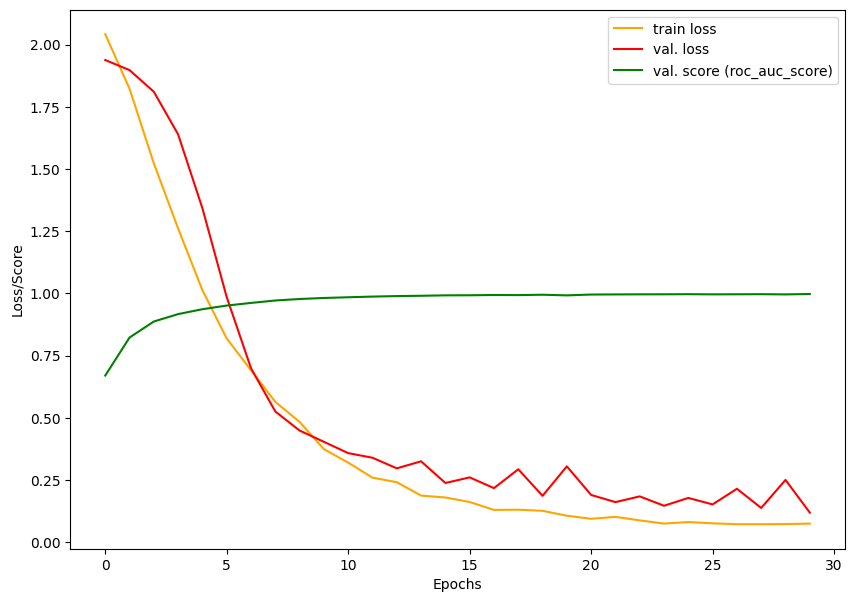

In [12]:
visuals.plots_train_val_metrics(
    train_losses=train_losses,
    val_scores=val_scores,
    val_losses=val_losses,
    figsize=(10, 7),
    image_pathname=None,
    val_score_name=best_params["scoring_func"],
)

In [13]:
from lib import predictions, utilities

test_pred_logits, test_true = predictions.predict_from_loader(
    loader=test_loader,
    model=best_gcn_model,
    multi_class_type="logits",
    device="cuda:0",
    return_true_targets=True,
    desc="Predicting...",
)

# print(test_pred)
print(test_pred_logits)
print(test_pred_logits.shape)
# F.softmax(test_pred_classes)

tensor([[ 0.9207,  1.0376, -1.5981,  ..., -0.8078, -0.5672, -0.9369],
        [-3.9687,  1.6434,  9.4318,  ..., -2.8841, -1.6376, -3.0125],
        [-3.3970,  2.8780,  9.1381,  ..., -2.4488, -2.3813, -3.0826],
        ...,
        [-2.0420,  0.5214, -1.4853,  ..., -0.3744, -2.8469, -0.4574],
        [-0.9249, -2.1032, -1.8194,  ...,  0.5772, -1.7305, -3.0854],
        [-2.7371, -1.9183, -1.3740,  ...,  1.1499,  1.1763, -3.0244]],
       device='cuda:0', grad_fn=<CatBackward0>)
torch.Size([8294, 7])


In [15]:
f1_score_ = utilities.compute_score(
    scoring_func=f1_score,
    true_target=test_true.cpu(),
    pred_target=test_pred_logits.detach().cpu(),
    task="multiclass_classification",
)
precision = utilities.compute_score(
    precision_score,
    true_target=test_true.cpu(),
    pred_target=test_pred_logits.detach().cpu(),
    task="multiclass_classification",
)
recall = utilities.compute_score(
    recall_score,
    true_target=test_true.cpu(),
    pred_target=test_pred_logits.detach().cpu(),
    task="multiclass_classification",
)
balanced_acc = utilities.compute_score(
    balanced_accuracy_score,
    true_target=test_true.cpu(),
    pred_target=test_pred_logits.detach().cpu(),
    task="multiclass_classification",
)

print(f"Balanced Acc. = {round(balanced_acc,3)}")
print(f"F1-Score      = {round(f1_score_,3)}")
print(f"Precision     = {round(precision,3)}")
print(f"Recall        = {round(recall,3)}")

Balanced Acc. = 0.937
F1-Score      = 0.934
Precision     = 0.936
Recall        = 0.935
